In [6]:
import numpy as np
import poke.poke_core as pol
import poke.plotting as plot
from astropy.io import fits
import astropy.units as u
import poppy
import matplotlib.pyplot as plt

In [7]:
pth = 'Subaru_M1-M3_750nm.fits'

jones_pupil = fits.open(pth)[0].data

# load jones pupil
pth = 'Subaru_M1-M3_750nm.fits'
jones_pupil = fits.open(pth)[0].data

# load scexao pupil
pupil_pth = 'scexao_pupil.fits'
pupil_data = fits.open(pupil_pth)[0].data

# Reclaim the complex numbers from the fits file ;-;
J11 = jones_pupil[:,:,0,0,0] + 1j*jones_pupil[:,:,0,0,1]
J12 = jones_pupil[:,:,0,1,0] + 1j*jones_pupil[:,:,0,1,1]

J21 = jones_pupil[:,:,1,0,0] + 1j*jones_pupil[:,:,1,0,1] 
J22 = jones_pupil[:,:,1,1,0] + 1j*jones_pupil[:,:,1,1,1] 

J11 *= pupil_data
J12 *= pupil_data
J21 *= pupil_data
J22 *= pupil_data

# Get Mueller Matrix
M = np.empty([4,4,J11.shape[0],J11.shape[1]],dtype='float64')
for i in range(J11.shape[0]):
    for j in range(J11.shape[1]):
        
        J = np.array([[J11[i,j],J12[i,j]],
                      [J21[i,j],J22[i,j]]])
        M[:,:,i,j] = np.real(pol.JonesToMueller(J))

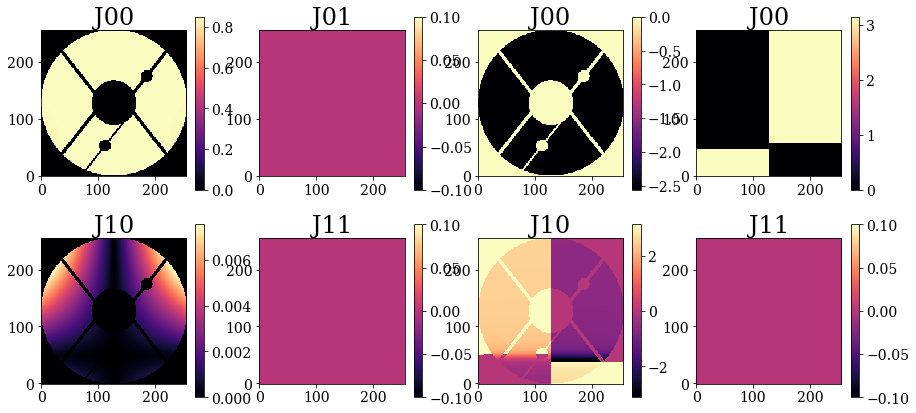

In [8]:
E = np.array([1,0])
plot.PlotJonesArray(J11*E[0],J12*E[1],J21*E[0],J22*E[1])

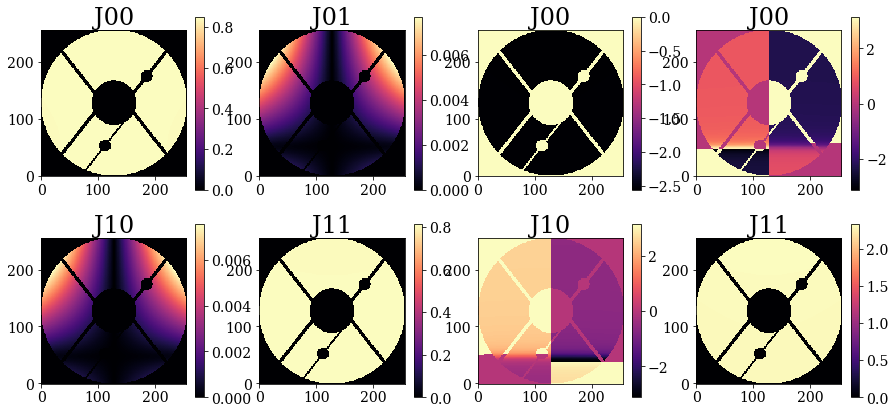

In [9]:
E = np.array([1,1j])
plot.PlotJonesArray(J11*E[0],J12*E[1],J21*E[0],J22*E[1])

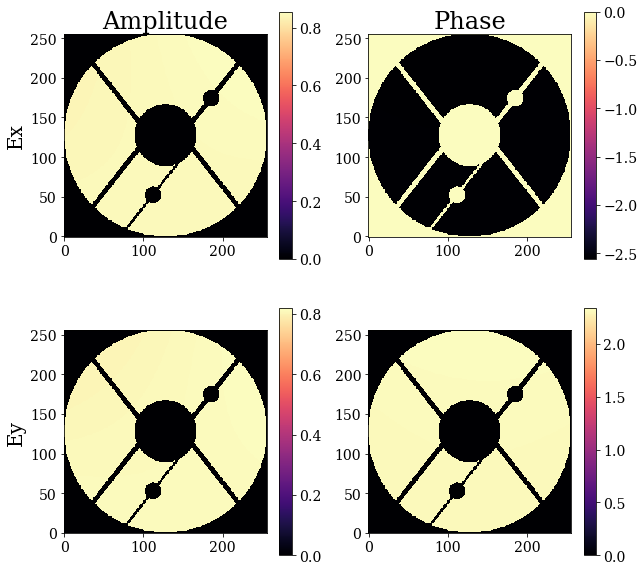

In [10]:
E = np.array([1,1j])
Ex_out = J11*E[0] + J12*E[1]
Ey_out = J12*E[0] + J22*E[1]

plt.figure(figsize=[10,10])
plt.subplot(221)
plt.imshow(np.abs(Ex_out))
plt.title('Amplitude')
plt.ylabel('Ex')
plt.colorbar()

plt.subplot(222)
plt.title('Phase')
plt.imshow(np.angle(Ex_out))
plt.colorbar()

plt.subplot(223)
plt.ylabel('Ey')
plt.imshow(np.abs(Ey_out))
plt.colorbar()

plt.subplot(224)
plt.imshow(np.angle(Ey_out))
plt.colorbar()

plt.show()

<ipython-input-11-69566ef44641>:2: RuntimeWarning: invalid value encountered in true_divide
  plot.MuellerPupil(M/pupil_data)


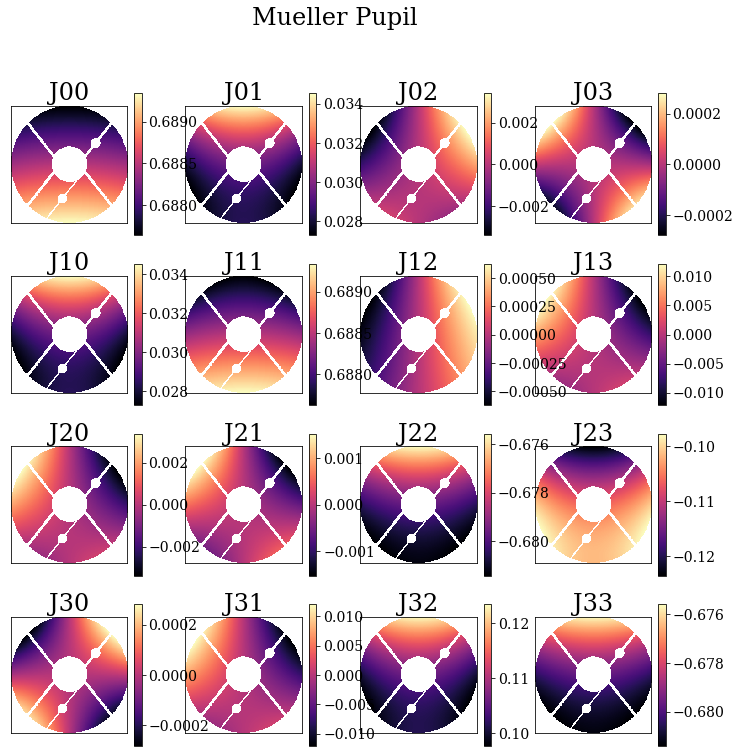

<ipython-input-11-69566ef44641>:3: RuntimeWarning: invalid value encountered in true_divide
  plot.MuellerPupil(M/pupil_data/M[0,0,:,:])


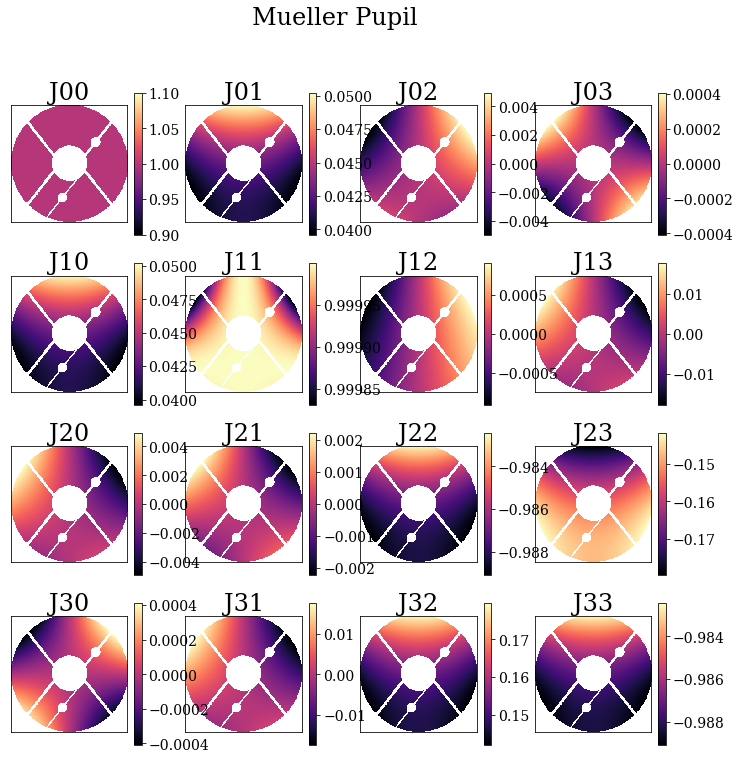

In [11]:
# This is important because it determines how polarizing an optic is!
plot.MuellerPupil(M/pupil_data)
plot.MuellerPupil(M/pupil_data/M[0,0,:,:])

<ipython-input-12-7e012f3372d0>:11: RuntimeWarning: invalid value encountered in true_divide
  P = np.sqrt(M10**2 + M20**2 + M30**2)/M00
<ipython-input-12-7e012f3372d0>:12: RuntimeWarning: invalid value encountered in true_divide
  D = np.sqrt(M01**2 + M02**2 + M03**2)/M00


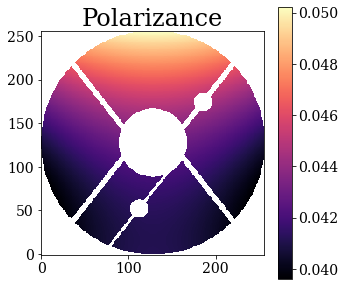

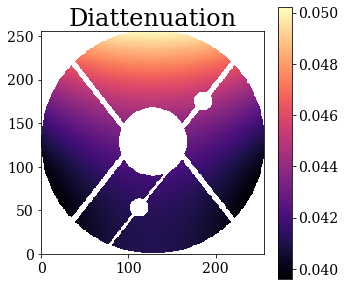

<ipython-input-12-7e012f3372d0>:28: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow(M00/pupil_data)
<ipython-input-12-7e012f3372d0>:32: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow(M10/M00)
<ipython-input-12-7e012f3372d0>:36: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow(M20/M00)
<ipython-input-12-7e012f3372d0>:40: RuntimeWarning: invalid value encountered in true_divide
  plt.imshow(M30/M00)


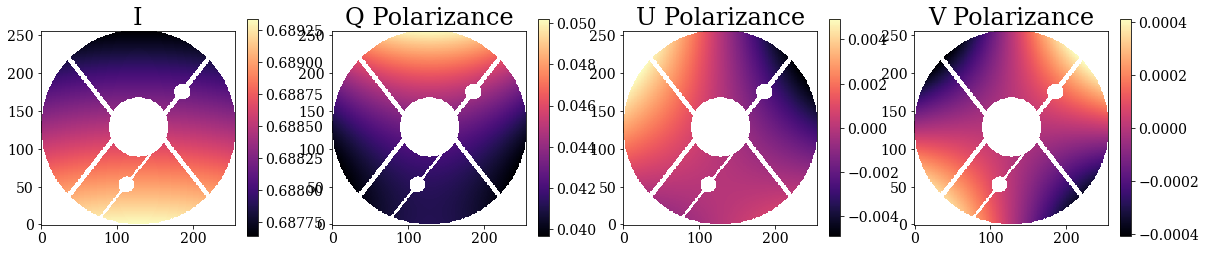

In [12]:
# Plot Polarizance
M00 = M[0,0,:,:]
M10 = M[1,0,:,:]
M20 = M[2,0,:,:]
M30 = M[3,0,:,:]

M01 = M[0,1,:,:]
M02 = M[0,2,:,:]
M03 = M[0,3,:,:]

P = np.sqrt(M10**2 + M20**2 + M30**2)/M00
D = np.sqrt(M01**2 + M02**2 + M03**2)/M00

plt.figure(figsize=[5,5])
plt.imshow(P)
plt.title('Polarizance')
plt.colorbar()
plt.show()

plt.figure(figsize=[5,5])
plt.imshow(D)
plt.title('Diattenuation')
plt.colorbar()
plt.show()

plt.figure(figsize=[20,4])
plt.subplot(141)
plt.imshow(M00/pupil_data)
plt.colorbar()
plt.title('I')
plt.subplot(142)
plt.imshow(M10/M00)
plt.title('Q Polarizance')
plt.colorbar()
plt.subplot(143)
plt.imshow(M20/M00)
plt.title('U Polarizance')
plt.colorbar()
plt.subplot(144)
plt.imshow(M30/M00)
plt.title('V Polarizance')
plt.colorbar()
plt.show()

In [13]:
import poppy

# Make Jones Array Optical Elements
def MakeArrayOpticalElement(jxx,wl,pixscal):

    trans = np.abs(jxx)
    opd = np.angle(jxx) * wl/(2*np.pi)

    optic = poppy.ArrayOpticalElement(transmission=trans,opd=opd,pixelscale=pixscal)

    return optic 

j11 = MakeArrayOpticalElement(J11,750e-9,8.2/256*u.m/u.pix)
j12 = MakeArrayOpticalElement(J12,750e-9,8.2/256*u.m/u.pix)
j21 = MakeArrayOpticalElement(J21,750e-9,8.2/256*u.m/u.pix)
j22 = MakeArrayOpticalElement(J22,750e-9,8.2/256*u.m/u.pix)

def PropagateToFocus(jxx):

    # load pupil
    pupil_pth = 'scexao_pupil.fits'
    pupil_data = fits.open(pupil_pth)[0].data

    pupil = poppy.ArrayOpticalElement(transmission=pupil_data,pixelscale=8.2*u.m/(pupil_data.shape[0]*u.pix))
    wf = poppy.FresnelWavefront(beam_radius=4.1*u.m,oversample=8,wavelength=750e-9*u.m)
    subaru_efl = 110.629*u.m
    osys = poppy.FresnelOpticalSystem()
    # osys.add_optic(poppy.CircularAperture(radius=4.1*u.m))
    osys.add_optic(pupil)
    osys.add_optic(jxx)
    osys.add_optic(poppy.QuadraticLens(subaru_efl))
    osys.add_optic(poppy.ScalarTransmission(),distance=subaru_efl)
    wfout = osys.propagate(wf)

    return wfout

j11_psf = PropagateToFocus(j11).wavefront
j12_psf = PropagateToFocus(j12).wavefront
j21_psf = PropagateToFocus(j21).wavefront
j22_psf = PropagateToFocus(j22).wavefront

After resampling, optic phasor shape (1024, 1024) is smaller than input wavefront (8192, 8192); will zero-pad the rescaled array.
After resampling, optic phasor shape (1024, 1024) is smaller than input wavefront (8192, 8192); will zero-pad the rescaled array.
After resampling, optic phasor shape (1024, 1024) is smaller than input wavefront (8192, 8192); will zero-pad the rescaled array.
After resampling, optic phasor shape (1024, 1024) is smaller than input wavefront (8192, 8192); will zero-pad the rescaled array.
After resampling, optic phasor shape (1024, 1024) is smaller than input wavefront (8192, 8192); will zero-pad the rescaled array.
After resampling, optic phasor shape (1024, 1024) is smaller than input wavefront (8192, 8192); will zero-pad the rescaled array.
After resampling, optic phasor shape (1024, 1024) is smaller than input wavefront (8192, 8192); will zero-pad the rescaled array.
After resampling, optic phasor shape (1024, 1024) is smaller than input wavefront (8192, 8

In [15]:
# Get Mueller Matrix
PSM = np.empty([4,4,j11_psf.shape[0],j11_psf.shape[1]],dtype='float64')
for i in range(j11_psf.shape[0]):
    for j in range(j11_psf.shape[1]):
        
        J = np.array([[j11_psf[i,j],j12_psf[i,j]],
                      [j21_psf[i,j],j22_psf[i,j]]])
        PSM[:,:,i,j] = np.real(pol.JonesToMueller(J))



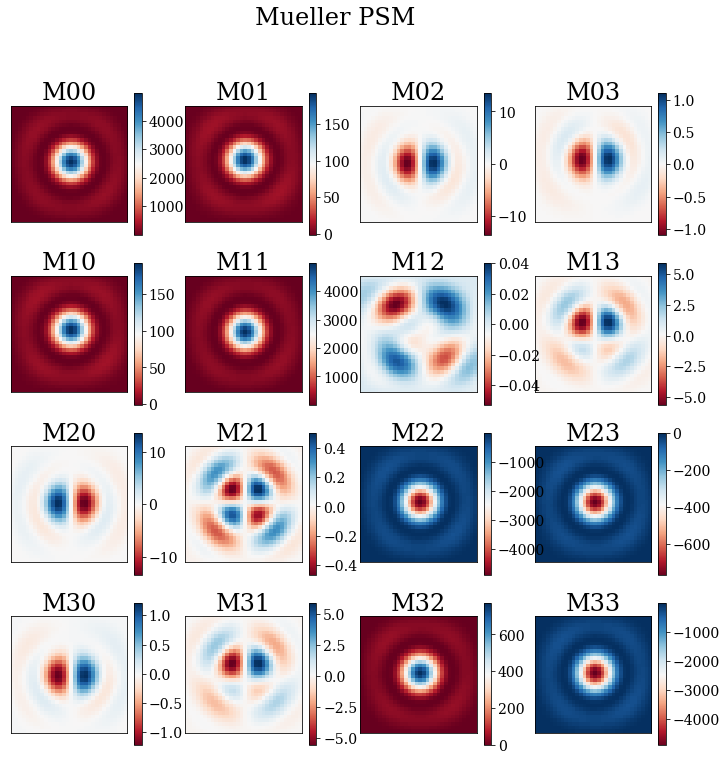

In [19]:
def PlotPSM(PSM):
    center = int(PSM.shape[2]/2)
    cut = 16
    from matplotlib.colors import LogNorm
    fig,axs = plt.subplots(figsize=[12,12],nrows=4,ncols=4)
    plt.suptitle('Mueller PSM')
    for i in range(4):
        for j in range(4):
            ax = axs[i,j]
            psf = PSM[i,j,center-cut:center+cut,center-cut:center+cut]
            ax.set_title('M{i}{j}'.format(i=i,j=j))
            sca = ax.imshow(psf,cmap='RdBu')
            fig.colorbar(sca,ax=ax)
            ax.axes.xaxis.set_visible(False)
            ax.axes.yaxis.set_visible(False)
    plt.show()

PlotPSM(PSM)

(4, 4, 256, 256)

In [ ]:
PSM.shape

(4, 4, 1024, 1024)

In [ ]:
3.5**2

12.25